In [ ]:
import random
import itertools
import numpy as np
from tqdm import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

Скачиваем геном E.coli

In [ ]:
# Геном e. coli
!gdown 1CMhLlCrhEC29U9OI3H41zvqoRZqN2HfG

Downloading...
From: https://drive.google.com/uc?id=1CMhLlCrhEC29U9OI3H41zvqoRZqN2HfG
To: /content/e_coli_genome.fasta
100% 4.71M/4.71M [00:00<00:00, 112MB/s]


In [ ]:
with open('e_coli_genome.fasta', 'r') as f:
    f.readline()
    genome = ''
    for line in f:
        line = line.strip()
        genome += line

Вырезаем куски 100kb, 10kb и 1kb

In [ ]:
import random
random.seed(42)

# 100kb
i = random.randint(0, len(genome) - 100_000)
e_coli_seq_100k = genome[i:i+100_000]

# 10kb
i = random.randint(0, len(genome) - 10_000)
e_coli_seq_10k = genome[i:i+10_000]

# 1kb
i = random.randint(0, len(genome) - 1000)
e_coli_seq_1k = genome[i:i+1000]

## Марковская цепь

In [ ]:
# вспомогательные функции
def occurrences(string, sub):
    """
    Искать перекрывающиеся подстроки в строке
    Пример
    >>>occurences('AAA', 'AA')
    >>>2
    """
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count += 1
        else:
            return count


def get_possible_combinations(alphabet, L):
    """
    Возвращает все возможные комбинации из алфавита alphabet длины L
    Пример:
    >>>get_possible_combinations('ATGC', 2)
    >>>['AA', 'AT', 'AG', 'AC', 'TA', 'TT', 'TG', 'TC',
        'GA', 'GT', 'GG', 'GC', 'CA', 'CT', 'CG', 'CC']
    """
    lst = list(itertools.product(alphabet, repeat=L))
    lst = [''.join(i) for i in lst]
    return lst


# основной класс
class MarkovChain:
    def __init__(self, order, alphabet):
        self.order = order
        self.alphabet = alphabet
        self.probabilities = None

    def init_probabilities(self):
        """
        Инициализация вероятностей переходов
        >>>init_probabilities("ATGC", 2)
        >>>['$$', '$A', '$T', '$G', '$C', 'AA', 'AT', 'AG', 'AC', 'TA', 'TT',
            'TG', 'TC', 'GA', 'GT', 'GG', 'GC', 'CA', 'CT', 'CG', 'CC']
        """
        # Начало - ключи, которые содержат хотя бы 1 $
        i = self.order
        init_probabilities = []
        while i != 0:
            left = "$" * i
            right = get_possible_combinations(self.alphabet, self.order - i)
            keys = [left + i for i in right]
            init_probabilities.extend(keys)
            i -= 1

        # основная часть
        keys = get_possible_combinations(self.alphabet, self.order)
        init_probabilities.extend(keys)

        # объединяем
        return init_probabilities


    def fit(self, seq):
        """
        Заполняет матрицу вероятностей в соответствии с последовательностью seq
        """
        seq = "$" * self.order + seq
        probabilities_keys = self.init_probabilities()
        probabilities = defaultdict(dict)
        for key in probabilities_keys:
            for base in self.alphabet:
                p_ab = occurrences(seq, key + base)
                p_b = occurrences(seq[:-1], key) # чтобы не засчитывать, если стоит
                                                 # замыкающим(чтоб всегда
                                                 # вероятности суммировались к 1)
                if p_b == 0:
                    probabilities[key][base] = 0
                else:
                    probabilities[key][base] = p_ab/p_b
        self.probabilities = dict(probabilities)

    def assess_loglikelihood(self, seq):
        """
        Оценивает натуральный логарифм правдоподобия последовательности
        """
        seq = '$' * self.order + seq
        lst = [seq[i:i+self.order+1] for i in range(len(seq) - self.order)]
        lst = [(seq[:-1], seq[-1]) for seq in lst]
        cnt = Counter(lst)
        logL = 0
        for pair, number in cnt.items():
            logL += np.log(self.probabilities[pair[0]][pair[1]]) * number
        return logL

    def bic(self, seq):
        """
        Оценивает BIC последовательности
        Возвращает кортеж (logL, BIC)
        """
        df = len(self.alphabet) ** (self.order + 1) - 1
        logL = self.assess_loglikelihood(seq)
        return logL, -2*logL + df * np.log(len(seq))

**Построим марковские цепи разного порядка на фрагментах генома E. Coli разной длины и оценим правдоподобия и BIC**

В словарях, которые выводятся:  
ключи - порядки модели  
значения - (logLikelihood, BIC)

In [ ]:
# для фрагмента 100kb строим модели с порядком от 0 дл 9 и оцениваем logLik и BIC
%%time
print('fragment 100kb')
logL_BIC_100k = {}
for i in tqdm(range(0, 10)):
    mc = MarkovChain(i, "ATGC")
    mc.fit(e_coli_seq_100k)
    logL_BIC_100k[i] = mc.bic(e_coli_seq_100k)
logL_BIC_100k

fragment 100kb


100%|██████████| 10/10 [22:02<00:00, 132.25s/it]

CPU times: user 21min 49s, sys: 3.25 s, total: 21min 52s
Wall time: 22min 2s


{0: (-138579.8359248294, 277194.2106260537),
 1: (-137292.39407425464, 274757.48203048384),
 2: (-135789.74149461373, 272304.7972935206),
 3: (-134818.98412577252, 272573.7642451124),
 4: (-133924.9700701608, 279627.6628909862),
 5: (-132362.36791470982, 311870.1656084727),
 6: (-126914.76710946583, 442445.79211153893),
 7: (-106998.43101533057, 968496.4323774851),
 8: (-64859.83901370029, 3147752.498191091),
 9: (-26978.819866213267, 12126123.459163584)}

In [ ]:
# для фрагмента 10kb строим модели с порядком от 0 дл 11 и оцениваем logLik и BIC
%%time
logL_BIC_10k = {}
for i in tqdm(range(0, 12)):
    mc = MarkovChain(i, "ATGC")
    mc.fit(e_coli_seq_10k)
    logL_BIC_10k[i] = mc.bic(e_coli_seq_10k)
print('fragment 10kb')
logL_BIC_10k

100%|██████████| 12/12 [37:03<00:00, 185.32s/it]

fragment 10kb
CPU times: user 36min 41s, sys: 8.9 s, total: 36min 50s
Wall time: 37min 3s


{0: (-13845.87651254501, 27719.38404620595),
 1: (-13693.938770322273, 27526.03264622419),
 2: (-13530.274058936075, 27640.79956130665),
 3: (-13373.339711192157, 29095.31621723824),
 4: (-13026.12692592084, 35474.43205237332),
 5: (-11624.09749521502, 60964.538813672516),
 6: (-7833.311129535056, 166559.62857315593),
 7: (-3458.933827508945, 610517.5239324771),
 8: (-1149.3308746030516, 2416724.917880159),
 9: (-360.6470860281027, 9658453.949716983),
 10: (-118.01847076536461, 38631194.29014235),
 11: (-40.20253647247681, 154523941.04889736)}

In [ ]:
%%time
# для фрагмента 1kb строим модели с порядком от 0 дл 12 и оцениваем logLik и BIC
logL_BIC_1k = {}
for i in tqdm(range(0, 13)):
    mc = MarkovChain(i, "ATGC")
    mc.fit(e_coli_seq_1k)
    logL_BIC_1k[i] = mc.bic(e_coli_seq_1k)
print('fragment 1kb')
logL_BIC_1k

100%|██████████| 13/13 [16:03<00:00, 74.11s/it] 

fragment 1kb
CPU times: user 15min 42s, sys: 15 s, total: 15min 57s
Wall time: 16min 3s


{0: (-1381.8604928836896, 2784.4442516043255),
 1: (-1347.5499291647454, 2798.716187514223),
 2: (-1290.6550205277395, 3016.4986236313534),
 3: (-1196.7352975104045, 4154.948191161254),
 4: (-881.3888974510302, 8829.411445300786),
 5: (-481.4569140319034, 29250.171695495657),
 6: (-201.25953356749503, 113572.27380269933),
 7: (-73.13380306576347, 452846.00981422584),
 8: (-22.180709777918235, 1810864.05351777),
 9: (-5.545177444479562, 7243310.582013583),
 10: (0.0, 28973218.689900614),
 11: (0.0, 115892895.48286828),
 12: (0.0, 463571602.654739)}

In [ ]:
# Вспомогательные функции, чтобы построить графики
def get_loglik(d):
    """
    возвращает 2 списка ([orders], [loglik])
    """
    orders = list(d.keys())
    loglik = [i[0] for i in d.values()]
    return orders, loglik

def get_bic(d):
    """
    возвращает 2 списка ([orders], [bic])
    """
    orders = list(d.keys())
    bic = [i[1] for i in d.values()]
    return orders, bic

Построим **зависимости logLik и BIC от порядка модели для последовательностей разной длины**

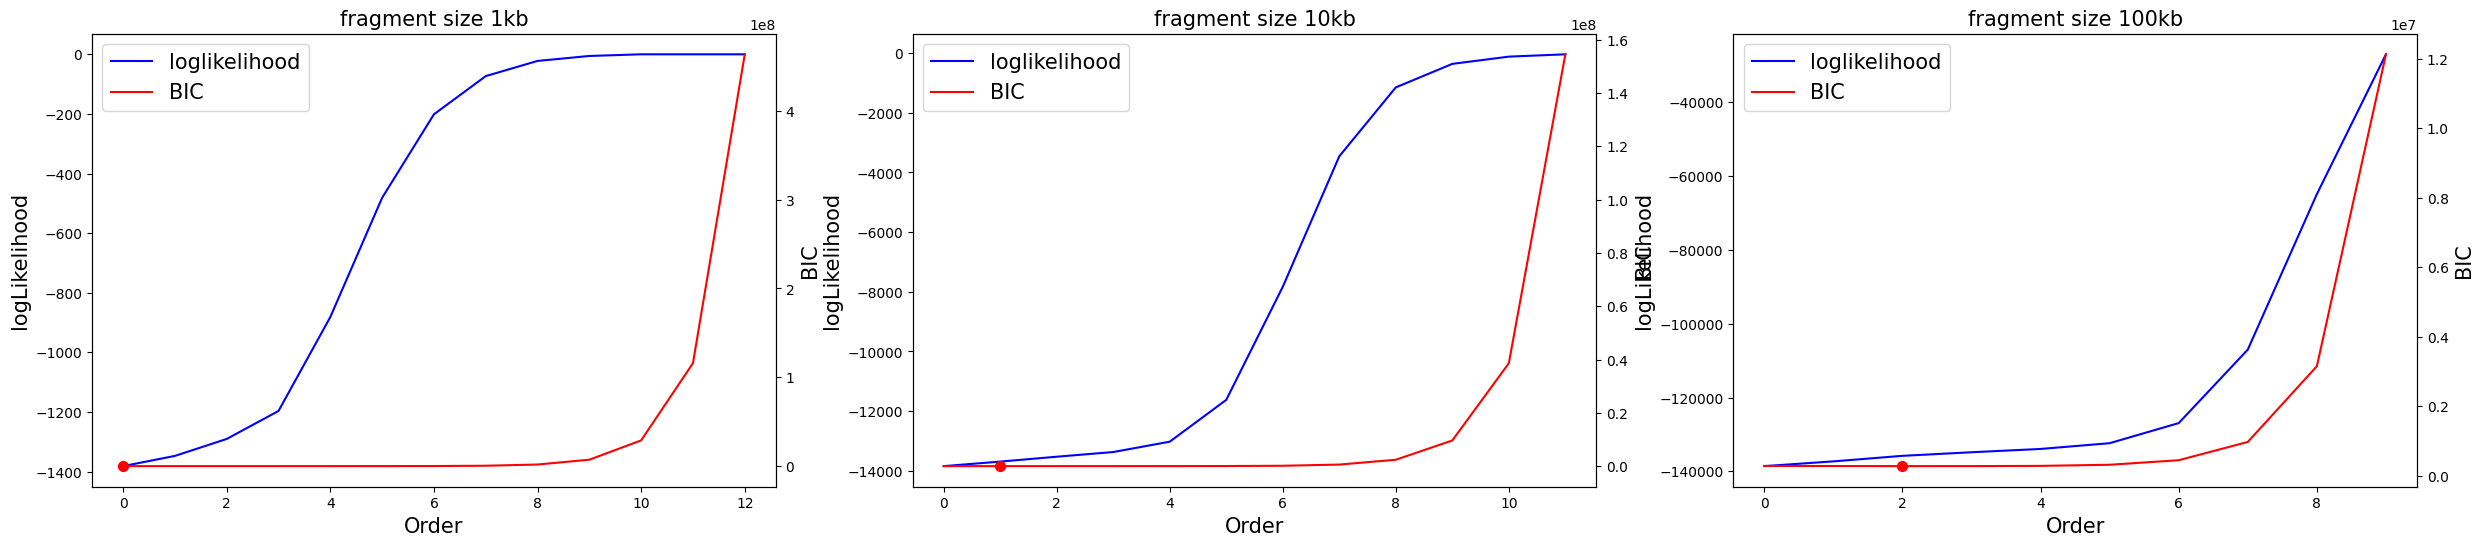

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30, 6), dpi=100)

def plot_bic_loglik(data, ax, title):
    """
    эта функция только для этой ячейки, тупо чтоб не копировать это 3 раза
    """
    ax_r = ax.twinx()
    p1, = ax.plot(*get_loglik(data), color='blue', label='loglikelihood')
    p2, = ax_r.plot(*get_bic(data), color='red', label='BIC')
    ax_r.scatter(np.argmin(get_bic(data)[1]), min(get_bic(data)[1]), s=50, c='red')
    ax_r.set_ylabel('BIC', fontsize=15)
    ax.set_xlabel('Order', fontsize=15)
    ax.set_ylabel('logLikelihood', fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.legend(handles=[p1, p2], fontsize=15)

plot_bic_loglik(logL_BIC_1k, ax[0], 'fragment size 1kb')
plot_bic_loglik(logL_BIC_10k, ax[1], 'fragment size 10kb')
plot_bic_loglik(logL_BIC_100k, ax[2], 'fragment size 100kb')

Увеличим левую часть графика, чтобы увидеть минимум BIC

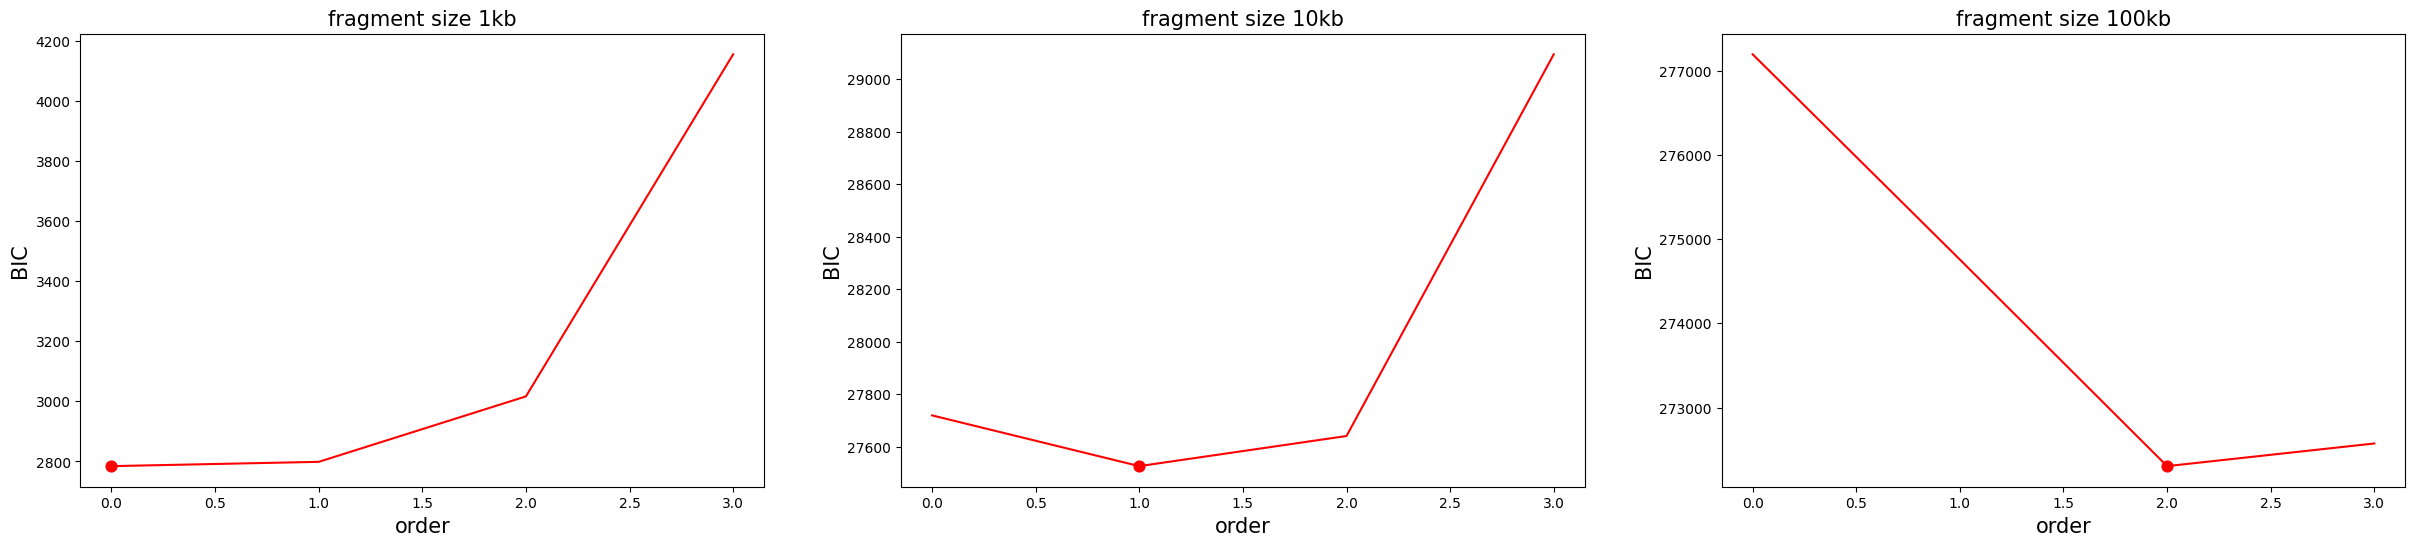

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30, 6), dpi=100)

points = [i[1] for i in logL_BIC_1k.values()][:4]
ax[0].plot(points, c='r')
ax[0].scatter(np.argmin(points), min(points), s=60, c='r')

points = [i[1] for i in logL_BIC_10k.values()][:4]
ax[1].plot(points, c='r')
ax[1].scatter(np.argmin(points), min(points), s=60, c='r')

points = [i[1] for i in logL_BIC_100k.values()][:4]
ax[2].plot(points, c='r')
ax[2].scatter(np.argmin(points), min(points), s=60, c='r')

for i in [0, 1, 2]:
    ax[i].set_xlabel('order', fontsize=15)
    ax[i].set_ylabel('BIC',  fontsize=15)
    ax[i].set_title(f"fragment size {1*10**i}kb", fontsize=15)

На 1kb 10kb, видим, что с увеличением порядка loglikelihood выходит на 0, что логично, так как начиная с определенного порядка модель запоминает последовательность целиком. При этом при больших порядках BIC растёт, так как правдоподобие не увеличивается, а число параметров при этом растёт  
Минимумы BIC наблюдаются при низких значениях порядка, причем это зависит от длины фрагмента:  
для 1kb order=0, то есть наиболее оптимальной является бернуллиевская модель  
для 10kb order=1  
для 100kb order=2  
Смотреть большие значение порядка смысла нет

**Теперь попробуем по 100 раз прогнать модели с порядком от 0 до 5 на фрагментах 1kb, 10kb и 100kb**  
Чтобы понять, является ли наш результат случайностью или нет

In [ ]:
def generate_random_fragment(genome, size):
    """
    вырезает рандомный кусок генома размера size
    """
    i = random.randint(0, len(genome) - size)
    fragment = genome[i:i+size]
    return fragment


def assess_fragment(fragment):
    """
    Обучает марковские модели порядка от 0 до 5 на fragment
    оценивает loglik и BIC
    """
    logL_BIC = {}
    for i in range(0, 6):
        mc = MarkovChain(i, "ATGC")
        mc.fit(fragment)
        logL_BIC[i] = mc.bic(fragment)
    return logL_BIC

In [ ]:
%%time
def get_optimal_orders(size, N):
    """
    Вырезает рандомный кусок из генома размером size, обучает на нем марковские
    цепи порядков от 0 до 5 и определяет лучший порядок по BIC N раз
    """
    opt_orders = []
    for _ in tqdm(range(N)):
        fragment = generate_random_fragment(genome, size)
        d = assess_fragment(fragment)
        opt_order = min(d, key=lambda key: d[key][1])
        opt_orders.append(opt_order)
    return opt_orders

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


Проверяем 100 рандомных кусков размеров 1kb, 10kb и 100kb, какой порядок модели для них наиболее оптимальный:

In [ ]:
random.seed(42)
opt_orders = {}
for size in [1000, 10_000, 100_000]:
    opt_orders[size] = get_optimal_orders(size, 100)

100%|██████████| 100/100 [11:19<00:00,  6.79s/it]


In [ ]:
opt_orders = {key: Counter(value) for key, value in opt_orders.items()}

Для миллиона отдельно, так как для него 100 раз - слишком долго

In [ ]:
%%time
opt_orders[1_000_000] = Counter(get_optimal_orders(1_000_000, 10))

100%|██████████| 10/10 [11:11<00:00, 67.16s/it]

CPU times: user 10min 57s, sys: 6.29 s, total: 11min 3s
Wall time: 11min 11s


**Выведем, сколько раз какой порядок оказался наиболее оптимальным для фрагментов разных длин:**

In [ ]:
opt_orders

{1000: Counter({0: 100}),
 10000: Counter({1: 91, 2: 9}),
 100000: Counter({2: 92, 3: 8}),
 1000000: Counter({4: 9, 3: 1})}

Видим, что для 1kb оптимальный порядок 0(бернуллиевская модель)  
10kb - 1  
100kb - 2  
1000kb - 4  
И правда есть зависимость оптимального порядка от длины фрагмента

### Распределение правдоподобий для фрагментов длины 10000

Возьмем модели порядков 1, 2 и 3

In [ ]:
%%time
random.seed(42)

logL_dict = {}
for order in [1, 2, 3]:
    lst = []
    for _ in tqdm(range(1000)):
        mc = MarkovChain(order, 'ATGC')
        fragment = generate_random_fragment(genome, 10_000)
        mc.fit(fragment)
        logL = mc.assess_loglikelihood(fragment)
        lst.append(logL)
    logL_dict[order] = lst

100%|██████████| 1000/1000 [00:59<00:00, 16.68it/s]

CPU times: user 1min 53s, sys: 699 ms, total: 1min 54s
Wall time: 2min 2s


Text(0.5, 1.0, 'logL distribution for 10kb fragment')

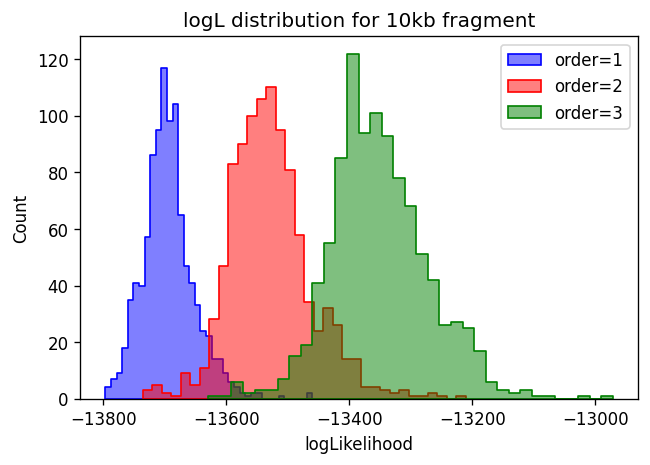

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(dpi=120)
sns.histplot(logL_dict[1], label='order=1', element='step', color='blue', alpha=.5)
sns.histplot(logL_dict[2], label='order=2', element='step', color='red', alpha=.5)
sns.histplot(logL_dict[3], label='order=3', element='step', color='green', alpha=.5)
ax.legend()
ax.set_xlabel('logLikelihood')
ax.set_title('logL distribution for 10kb fragment')

Чем больше порядок, тем больше правдоподобие - неудивительно, хотя они перекрываются

# Выводы

* Для фрагментов генома разной длины наиболее оптимальны с точки зрения BIC модели разных порядков:  
  - для 1kb - 0 порядка
  - для 10kb - 1 порядка
  - для 100kb - 2 порядка  
  - для 1000kb - 4 порядка(но это не точно)   

  То есть триплетность не играет такой важной роли, как можно было бы ожидать  
  Но зато работает принцип, что чем больше выборка, тем более сложную модель следует выбирать    
* С увеличением порядка модели правдоподобие последовательности увеличивается и начиная с определенного порядка выходит на 1(в случае logLik на 0). Ожидаемо - с какого-то момента модель просто выучивает всю последовательность(наблюдали на 1kb и 10kb).  
При этом BIC, как правило, имеет один минимум, а затем начинает резко расти. Это связано с тем, что Likelihood с увеличением порядка выходит на плато, а число параметров при этом экспоненциально растёт
